In [1]:
import pandas as pd
import numpy as np
import re
import os 
import matplotlib.pyplot as plt
output_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'data/firing_rates'))
import seaborn as sns
sns.set_style("darkgrid")
import yaml
import itertools
import ssm 
from ssm.plots import gradient_cmap
from stim_functions import figure_style

In [2]:
# functions

def load_firing_rates(output_dir, file_name):
    """
    Load data of firing rates
    output_dir: folder where the firing rates are saved
    Returns: Data Frame with state for all regions 
    """
    
    # load data 
    frate_E_sync = pd.read_csv(os.path.join(output_dir, f'frateE_{file_name}.csv'))
    frate_I_sync = pd.read_csv(os.path.join(output_dir, f'frateI_{file_name}.csv'))
    frate_A_sync = pd.read_csv(os.path.join(output_dir, f'frateA_{file_name}.csv')) 

    ratesG = np.array((frate_E_sync, frate_I_sync, frate_A_sync))
    return ratesG


def extract_file_info(output_dir, file_name):
    
    # load settingsfile 
    settings_file = os.path.join(output_dir, file_name+'_expsettings.yml')
    
    with open(settings_file, 'r', encoding='utf8') as f_in:
        settings = yaml.safe_load(f_in)
        
    G = settings['Parameter']['G']
    S = settings['Parameter']['S']
    
    return [G, S]

def extract_session_nr(filename):
    '''
    Extract the session number from the file name.
    '''
        
    pattern = r'sessions_(\d+)'

    # use re.search to find the first occurrence of the pattern in the filename
    match = re.search(pattern, filename)

    if match:
        session = match.group(1)
    else:
        session = None
        
    return session

def calc_HMM_states(firing_rate_I):
    '''
    Calculate the Up and down states of a time series
    '''
    
    # parameters for the HMM for finding Up and Down states 
    K = 2    # number of discrete states
    D = 1    # dimension of the observations

    # make an hmm and sample from it
    simple_hmm = ssm.HMM(K, D, observations='gaussian')

    # Fit HMM on all data
    trial_data = np.expand_dims(np.array(firing_rate_I), axis=1)
    lls = simple_hmm.fit(trial_data, method='em', transitions='sticky')
    posterior = simple_hmm.filter(trial_data)
    zhat = simple_hmm.most_likely_states(trial_data)
    # check if 1 and 0 state has to be turned around
    # so that 1 is up and 0 is down 
    if np.mean(trial_data[zhat==0]) > np.mean(trial_data[zhat==1]):
        zhat = np.where((zhat==0)|(zhat==1), zhat^1, zhat)
        p_down = posterior[:, 1]
    else:
        p_down = posterior[:, 0]
    
    return zhat, p_down

def get_all_states(output_dir, file_name, save_states=True):
    """
    Compute the up and down states for all of the regions in this session.
    output_dir: folder where the firing rates are saved
    file_name: name of the csv file, without the rate specification
    Returns: Data Frame with state for all regions 
    """
    
    # load data 
    regions_states = pd.DataFrame()
    frate_E_sync = pd.read_csv(os.path.join(output_dir, f'frateE_{file_name}.csv'))
    frate_I_sync = pd.read_csv(os.path.join(output_dir, f'frateI_{file_name}.csv'))
    frate_A_sync = pd.read_csv(os.path.join(output_dir, f'frateA_{file_name}.csv')) 

    ratesG = np.array((frate_E_sync, frate_I_sync, frate_A_sync))

    for i in range(ratesG.shape[2]):

        zhat, p_down = calc_HMM_states(ratesG[1, :, i])

        # safe the states in this dataframe
        regions_states = pd.concat((regions_states, pd.DataFrame(data={
        'state': zhat, 'p_down': p_down, 'region': i})))
    
    if save_states:
        regions_states.to_csv(os.path.join(output_dir, file_name+'_states.csv'))
    
    return regions_states


def compute_state_analysis(output_dir, file_name):
    """
    File should be the From the data frame with state info calculate the most important parameter for every 
    region time series.
    G value, thetaE, beta, thetaE stimulation, serotonin stimulation times, and the most important parameters:
    Description of the parameters:
    f_s - frequency of states
    d_down - average duration of down-states
    d_up - average duration of up-states
    p_down - proportion time in state 0
    p_up - proportion time in state 1 
    brunel_X - quantifies synchrony: 0 low, 1 high
    """
    
    # check if it is a session
    session = extract_session_nr(file_name)
            
    # check if any files in the directory end with 'states.csv'
    if any(f.endswith(f'{session}_states.csv') for f in os.listdir(output_dir)):
        pass
    else:
        print('The folder does not contain a file with the ending "states.csv"')
        _ = get_all_states(output_dir, file_name)
        

        
    region_states = pd.read_csv(os.path.join(output_dir, f'{file_name}_states.csv'))
    state_statistics = pd.DataFrame()
    
    # get infos about session (for saving it later)
    G, _ = extract_file_info(output_dir, file_name)

    # load atlas with releveant regions for plotting
    atlas = pd.read_csv('relevant_areas.csv')
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)
    
    for i, region in enumerate(np.unique(region_states['region'])):
    
        # get the time series for this region
        time_series = list(region_states[region_states['region']==region]['state'])
        trial_duration = len(time_series)

        # count the number of occurrences of 0 and 1
        num_zeros = time_series.count(0)
        num_ones = time_series.count(1)

        # calculate the duration of each state (in number of time steps)
        zero_durations = [sum(1 for _ in group) for key, group in itertools.groupby(time_series) if key == 0]
        one_durations = [sum(1 for _ in group) for key, group in itertools.groupby(time_series) if key == 1]
                
        # calculate the frequency of the states (I use the up-state here) 
        f_s = (len(one_durations)/trial_duration)*1000
        
        # calculate the average state durations 
        d_down = np.mean(zero_durations)
        d_up = np.mean(one_durations)

        # calculate the total duration of each state (in number of time steps)
        total_zero_duration = sum(zero_durations)
        total_one_duration = sum(one_durations)

        # calculate the proportion of time spent in each state
        prop_zero = total_zero_duration / len(time_series)
        prop_one = total_one_duration / len(time_series)

        # collect the values in the dataframe 
        state_statistics = pd.concat((state_statistics, pd.DataFrame(data={'state_frequency': f_s, 'd_down': d_down,
                                                                           'd_up' : d_up, 'p_down' : prop_zero,
                                                                           'p_up' : prop_one,
                                                                           'region': atlas[i][0], 'G' : G, 
                                                                           'session': session}, index=[0])))
        
    return state_statistics


def compute_transitions(G_params, S_params, region, window_length, pre_stim, sessions, thetaE=-1, beta=6, extra=''):
    ''' 
    G_params: list of G parameter 
    S_params: list of S parameter 
    region: brain region
    window_length: length of window around stimulation onset
    pre_stim: time to plot before stimulation onset (subtracted from entire window in the end)
    '''
    
    times = np.arange(-pre_stim, window_length-pre_stim, 1)
    all_windows = pd.DataFrame()
    state_trans_df = pd.DataFrame()
    sessions = sessions
    state_all_windows = pd.DataFrame()


    for S in S_params:
        for G in G_params:
            p_state_change_all = []
           
            session_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_sessions' 
            for session in sessions:
                
                file_dir = os.path.join(output_dir, session_name)
                file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_sessions_{session}'
                states = pd.read_csv(os.path.join(file_dir, file_name+'_states.csv'), index_col=0)
                states_region = states[states['region']==region]
                # get the time window around the stimulation 
                times_array = pd.read_csv(os.path.join(file_dir, file_name+'_stimulation_times.csv')).to_numpy()

                # first check if all time windows are big enough 
                # (e.g., sometimes the last simulation is too close to the end of the trial)
                windows = []
                for win in times_array:
                    start = win[0] - pre_stim
                    state_window = states_region[start:start+window_length]
                    if len(state_window) == window_length:
                        windows.append(start)
                        
                trans_mat = np.empty((len(windows),len(times)))
                        
                for i, start in enumerate(windows):
                    state_window = states_region[start:start+window_length]

                    # the state changes
                    zhat = state_window['state']
                    #print('zhat', zhat[145:155])
                    state_change_up = np.concatenate((np.diff(zhat) > 0, [False])).astype(int)
                    state_change_down = np.concatenate((np.diff(zhat) < 0, [False])).astype(int)
                    
                    state_all_windows = pd.concat((state_all_windows, pd.DataFrame(data={'session': session, 'window': i, 'p_down':state_window['p_down'],
                                                                             'p_state_change_up': state_change_up, 'p_state_change_down': state_change_down,
                                                                             'time':times, 'state':zhat,
                                                                             'region':region, 'G' : G, 'S' : S})))
                    
            
    return state_all_windows 


def plot_transitions(data, S, G_params, region, savefig=False, fileout=''):
    """
    Plot the probability of the down state.
    data: transition data of sessions. The stimulation windows are 
    """
    
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(8,7))

    # load atlas with releveant regions for plotting
    atlas = pd.read_csv('relevant_areas.csv')
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)

    for i, G in enumerate(G_params):
        print(G)
        axes[i].axvspan(0, 1000, alpha=0.1, color='royalblue')
        axes[i].set_xlim(-150, 1350)
        axes[i].plot([-150, 1350], [0.5, 0.5], ls='--', color='grey')
        Gdata = data[data['G']==G]
        data_grouped = Gdata.groupby(['session', 'S', 'time'], as_index=False).mean('p_down')
        data_grouped_S = data_grouped[data_grouped['S'].isin(S)]
        sns.lineplot(data_grouped_S, x='time', y='p_down', hue='S', ax=axes[i], palette=['#ff7f0e', '#2ca02c', '#d62728'])
        axes[i].set_ylabel('Down state prob. (%)', fontsize=12)
        axes[i].set_xlabel('time (ms)', fontsize=12)
        axes[i].set(yticks=[0, 0.5, 1], yticklabels=[0, 50, 100])
        axes[i].set_title(f'coupling strength (G) = {G}', fontsize=10)
        plt.legend(loc='center right', title='serotonin stim. strength')  
        if i < 2:
            axes[i].get_legend().remove()
        
    
    fig.suptitle(f'{atlas[region][0]} - downstate probability during stimulation (S={S}) period', fontsize=15)
    if savefig:
        plt.savefig(f'transition_{atlas[region][0]}_p_down_S{S}{fileout}.pdf', transparent=False, bbox_inches = 'tight')        
        plt.savefig(f'transition_{atlas[region][0]}_p_down_S{S}{fileout}.jpg', transparent=False, bbox_inches = 'tight')

In [3]:
serotonin_params = pd.read_csv("serotonin_stimulation_analysis_all_sessions.csv")
serotonin_params_inhibit = pd.read_csv("serotonin_stimulation_analysis_all_sessions_InhibitPop.csv")

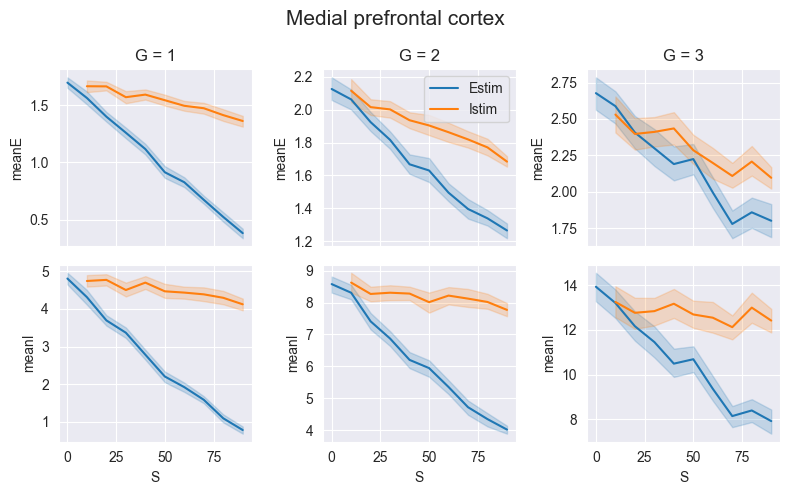

In [22]:
# S on the x axis
fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(8,5))
G_plot = [1, 2, 3]
region = 'Medial prefrontal cortex' 

region_data = serotonin_params[serotonin_params['region']==region]
region_data_inhibit = serotonin_params_inhibit[serotonin_params_inhibit['region']==region]

for i, G in enumerate(G_plot):
    Gdata = region_data[region_data['G']==G]
    Gdata_inhibit = region_data_inhibit[region_data_inhibit['G']==G]
    sns.lineplot(Gdata, x='S', y='meanI', ax=axes[1][i])
    sns.lineplot(Gdata_inhibit, x='S', y='meanI', ax=axes[1][i])
    
    if i == 1:
        sns.lineplot(Gdata, x='S', y='meanE', ax=axes[0][i], label='Estim')
        sns.lineplot(Gdata_inhibit, x='S', y='meanE', ax=axes[0][i], label='Istim')
    else:
        sns.lineplot(Gdata, x='S', y='meanE', ax=axes[0][i])
        sns.lineplot(Gdata_inhibit, x='S', y='meanE', ax=axes[0][i])   
        
    axes[0][i].set_title(f'G = {G}')

fig.suptitle(region, fontsize=15)
plt.tight_layout()

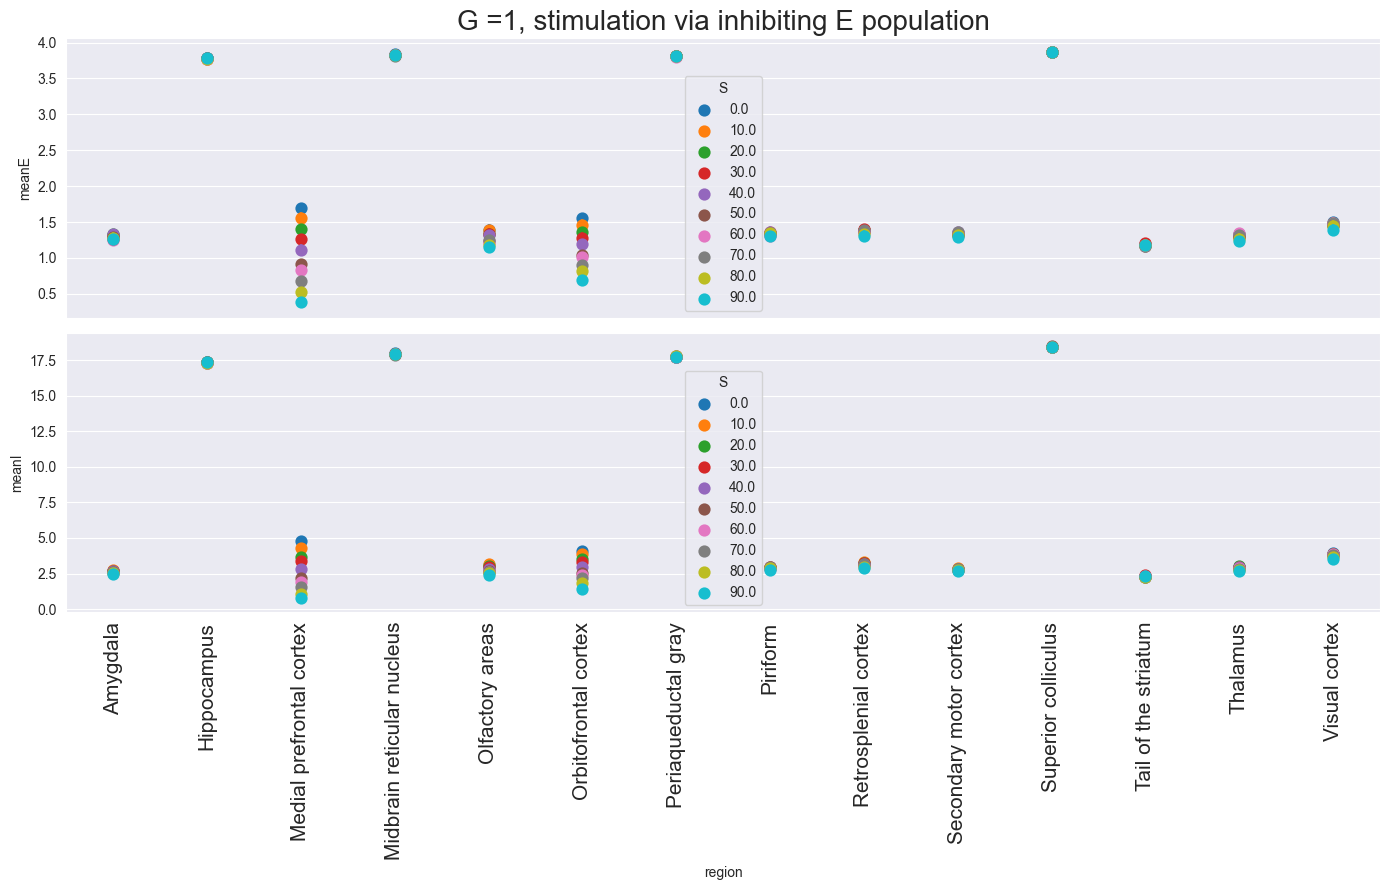

In [5]:
# plot the S change for every region
# choose one G
G = 1
plotG = serotonin_params[serotonin_params['G']==G]
# x axis - region
# y axis - change

# per parameter plot the values for each region
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14,9))


sns.pointplot(plotG, x='region', y='meanE', hue='S', ax=axes[0], join=False)
sns.pointplot(plotG, x='region', y='meanI', hue='S', ax=axes[1], join=False)

axes[1].set_xticklabels(np.unique(serotonin_params['region']), rotation = 90, fontsize=15)
for ax in axes:
    ax.label_outer()

axes[0].set_title(f"G ={G}, stimulation via inhibiting E population", fontsize=20)
plt.tight_layout()
plt.show()

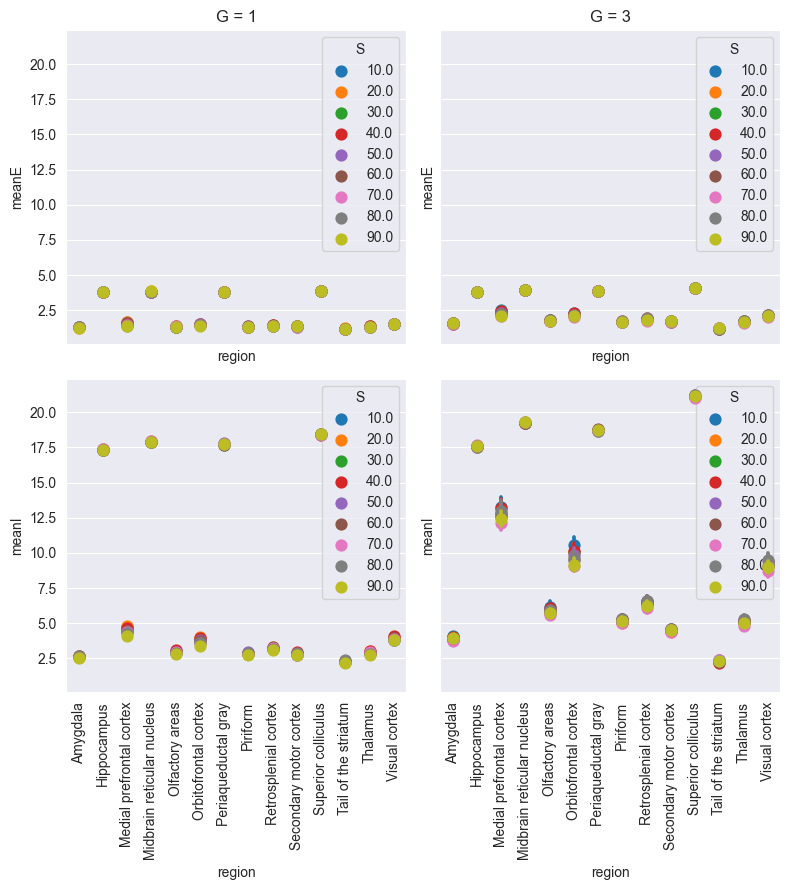

In [6]:
# INHIBITORY STIMULATION
0, 1,2,3,5,6,7,9, 10, 11, 12, 13
# plot the S change for every region
# choose one G
G_plot = [1, 3] 

# x axis - region
# y axis - change

# per parameter plot the values for each region
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,9))

for i, G in enumerate(G_plot):
    
    plotG = serotonin_params_inhibit[serotonin_params_inhibit['G']==G]
    sns.pointplot(plotG, x='region', y='meanE', hue='S', ax=axes[0][i], join=False)
    sns.pointplot(plotG, x='region', y='meanI', hue='S', ax=axes[1][i], join=False)

    axes[1][i].set_xticklabels(np.unique(serotonin_params['region']), rotation = 90)
    
        
    axes[0][i].set_title(f'G = {G}')

#for ax in axes:
#    for ax_i in ax:
#        ax_i.label_outer()

plt.tight_layout()
plt.show()

In [7]:
# plot the duration until next state change


0


No handles with labels found to put in legend.


2


No handles with labels found to put in legend.


4


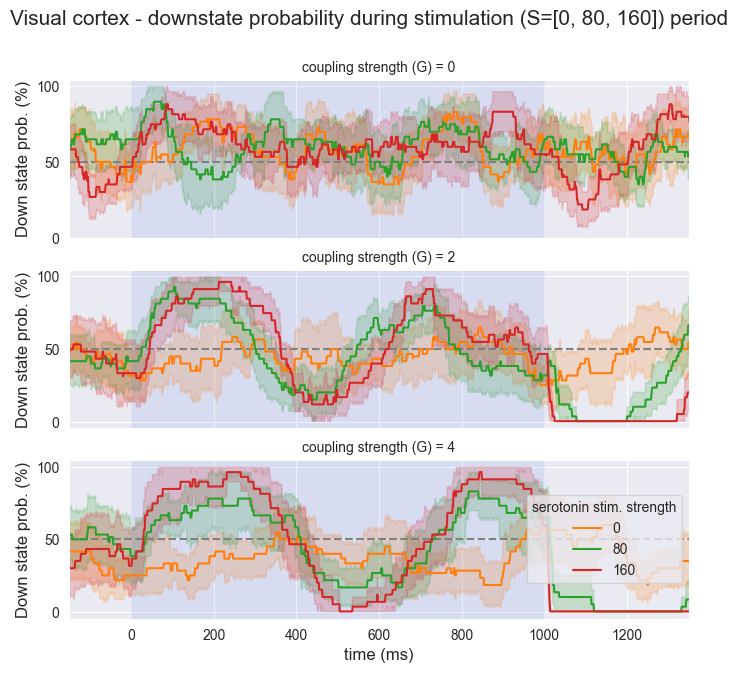

In [112]:
# compute the transitions (p state change and p down/up)
region = 13
window_duration = 1950
pre_stim = 500
extra = 'NewDRN'
sessions = np.arange(0,10,1)
state_all_windows = compute_transitions([0,2,4], [0, 80, 160], region, window_duration, pre_stim, sessions, extra=extra)

# mean over the windows per session
mean_transition_windows = state_all_windows.groupby(['S', 'session', 'G', 'time'], as_index=False).mean()
plot_transitions(mean_transition_windows, S=[0, 80, 160], G_params=[0,2,4], region=region, savefig=True, fileout=extra)


0


No handles with labels found to put in legend.


2


No handles with labels found to put in legend.


4


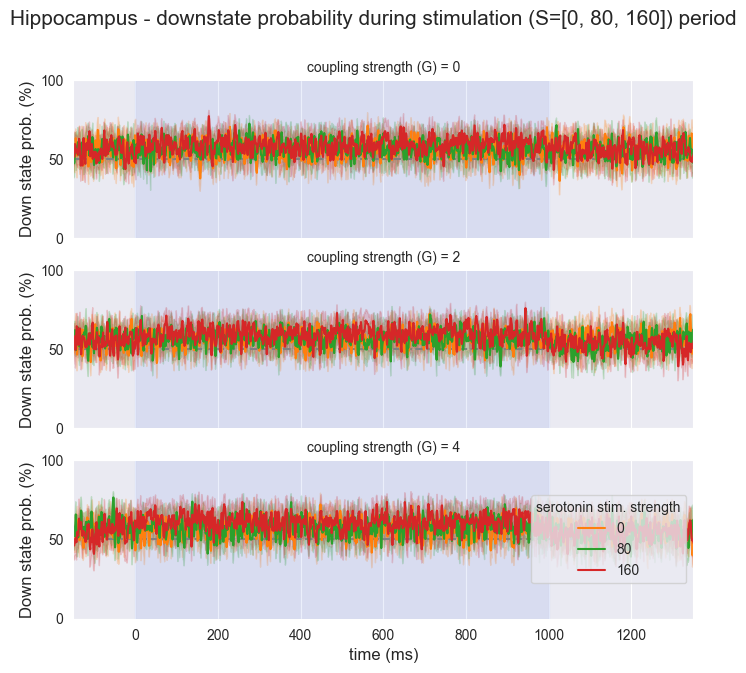

In [111]:
# compute the transitions (p state change and p down/up)
region = 1
window_duration = 1950
pre_stim = 500
extra = 'NewDRN'
sessions = np.arange(0,10,1)
state_all_windows = compute_transitions([0,2,4], [0, 80, 160], region, window_duration, pre_stim, sessions, extra=extra)

# mean over the windows per session
mean_transition_windows = state_all_windows.groupby(['S', 'session', 'G', 'time'], as_index=False).mean()
plot_transitions(mean_transition_windows, S=[0, 80, 160], G_params=[0,2,4], region=region, savefig=True, fileout=extra)

In [138]:
# compute the transitions (p state change and p down/up)
region = 0
window_duration = 1950
pre_stim = 500
extra = 'RateAdj1'
sessions = np.arange(0,10,1)
state_all_windows = compute_transitions([0,2,4], [0, 80], region, window_duration, pre_stim, sessions, extra=extra)

# mean over the windows per session
mean_transition_windows = state_all_windows.groupby(['S', 'session', 'G', 'time'], as_index=False).mean()
plot_transitions(mean_transition_windows, S=[0, 80, 160], G_params=[0,2,4], region=region, savefig=True, fileout=extra)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\gross\\OneDrive - UvA\\Documents\\MBCS Amsterdam\\Research_Project_2_Champalimaud\\Code\\SerotoninModelling\\data\\firing_rates\\14areas_G0.0_S0.0_thetaE-1_beta6RateAdj_sessions\\14areas_G0.0_S0.0_thetaE-1_beta6RateAdj_sessions_0_states.csv'

0


No handles with labels found to put in legend.


2


No handles with labels found to put in legend.


4


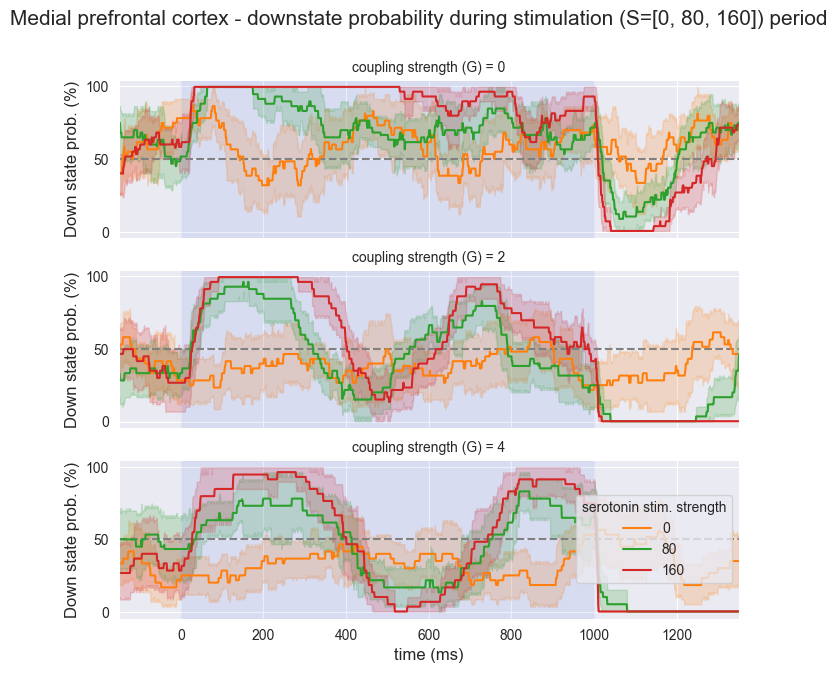

In [109]:
# compute the transitions (p state change and p down/up)
region = 2
window_duration = 1950
pre_stim = 500
extra = 'NewDRN'
sessions = np.arange(0,10,1)
state_all_windows = compute_transitions([0,2,4], [0, 80, 160], region, window_duration, pre_stim, sessions, extra=extra)

# mean over the windows per session
mean_transition_windows = state_all_windows.groupby(['S', 'session', 'G', 'time'], as_index=False).mean()
plot_transitions(mean_transition_windows, S=[0, 80, 160], G_params=[0,2,4], region=region, savefig=True, fileout=extra)

nr bins 75.0
bin length 75


C:\Users\gross\AppData\Local\Temp\ipykernel_27000\3892609275.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sdata['bin'] = np.tile(digitized, 10)
C:\Users\gross\AppData\Local\Temp\ipykernel_27000\3892609275.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sdata['bin'] = np.tile(digitized, 10)
C:\Users\gross\AppData\Local\Temp\ipykernel_27000\3892609275.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

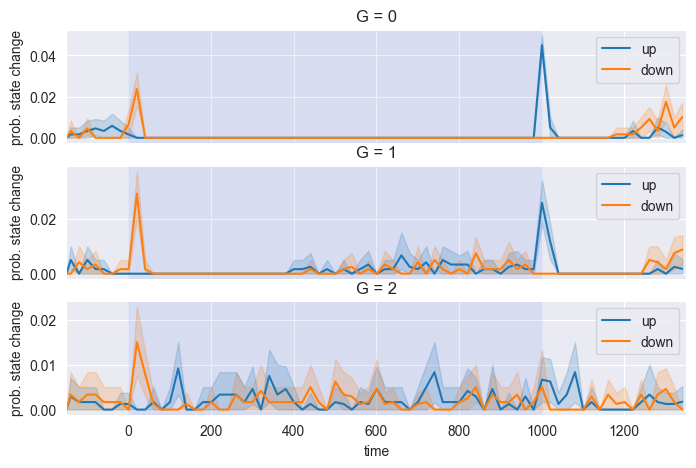

In [16]:
max_time = len(np.unique(mean_transition_windows['time']))
bin_size = 20 # in ms, so 50 ms
nr_bins = max_time/bin_size
print('nr bins', nr_bins)
bins = np.linspace(-150, max_time-150, int(nr_bins), endpoint=False)
print('bin length', len(bins))

# load atlas with releveant regions for plotting
atlas = pd.read_csv('relevant_areas.csv')
atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
atlas = np.array(atlas)

digitized = np.digitize(np.unique(mean_transition_windows['time']), bins, right=True)

fig, axes = plt.subplots(3,1 , sharex=True, sharey=False, figsize=(8,5))
G_plot = [0, 1, 2]
S = 90

for i, G in enumerate(G_plot):
    axes[i].axvspan(0, 1000, alpha=0.1, color='royalblue')
    axes[i].set_xlim(-150, 1350)
    Gdata = mean_transition_windows[mean_transition_windows['G']==G]
    Sdata = Gdata[Gdata['S']==S]
    
    Sdata['bin'] = np.tile(digitized, 10)
    data_grouped_bins = Sdata.groupby(['session', 'bin'], as_index=False).mean()
    sns.lineplot(data_grouped_bins, x='time', y='p_state_change_up', ax=axes[i], label='up')
    sns.lineplot(data_grouped_bins, x='time', y='p_state_change_down', ax=axes[i], label='down')
    axes[i].set_ylabel('prob. state change')
    axes[i].legend()
    axes[i].set_title(f'G = {G}')
    

#plt.savefig(f'prob_state_change_{atlas[region][0]}_S{S}.pdf', transparent=False, bbox_inches = 'tight')

Compute states

In [128]:
# compute the paramters of serotonin stimulation for different G and S values
G_params = [2] #np.arange(0, 6, 2)
S_params = [0]  #np.arange(0,100,40)
session_params = pd.DataFrame()
brunel_X_df = pd.DataFrame()
extra = "NewDRN_J_sessions"
filename_out = ''
thetaE= -1
beta = 6
session_params = pd.DataFrame()
brunel_X_df = pd.DataFrame()
sessions = np.arange(0,5,1)
all_analyses = pd.DataFrame()

for G in G_params:
    for S in S_params:
        for session in sessions:
            print(f"Run: S={S}, G={G}, session={session}")
            # load the file name
            session_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
            file_dir = os.path.join(output_dir, session_name)
            file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_{session}'
            all_analyses = pd.concat((all_analyses, compute_state_analysis(file_dir, file_name)))

Run: S=0, G=2, session=0
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=1
Run: S=0, G=2, session=2
Run: S=0, G=2, session=3
Run: S=0, G=2, session=4


In [ ]:
brunel_X_df.to_csv(f'brunelX_all_sessions_{extra}{filename_out}.csv', index=False) 
session_params.to_csv(f'serotonin_stimulation_analysis_all_sessions_{extra}{filename_out}.csv', index=False)

In [88]:
# compute the paramters of serotonin stimulation for different G and S values
G_params = [2] #np.arange(0, 6, 2)
S_params = [0]  #np.arange(0,100,40)
session_params = pd.DataFrame()
brunel_X_df = pd.DataFrame()
extra = "RateAdj1_sessions"
filename_out = ''
thetaE= -1
beta = 6
session_params = pd.DataFrame()
brunel_X_df = pd.DataFrame()
sessions = [0] # np.arange(0,5,1)
all_analyses = pd.DataFrame()
time_params = np.arange(1,3,0.5)
G = 2

for time_scale in time_params:
    extra = f"_{time_scale}time_sessions"
    for S in S_params:
        for session in sessions:
            print(f"Run: S={S}, G={G}, session={session}")
            # load the file name
            session_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
            file_dir = os.path.join(output_dir, session_name)
            file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_{session}'
            all_analyses = pd.concat((all_analyses, compute_state_analysis(file_dir, file_name)))

Run: S=0, G=2, session=0
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=0
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=0
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=0
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
zhat = [0, 0, 1, 0, 0, 1, 0]

In [7]:
np.concatenate((np.diff(zhat) > 0, [False])).astype(int)

array([0, 1, 0, 0, 1, 0, 0])

In [25]:
# get states from local circuit runs 
output_dir_locCir = 'C:\\Users\\gross\\OneDrive - UvA\\Documents\\MBCS Amsterdam\\Research_Project_2_Champalimaud\\Code\\LocalCircuitModelJercog2013\\data'

# local coupling and theta parameters
thetaE_params =  np.arange(-2, 4, 0.5)
L_params =  np.arange(0.6, 1.2, 0.01)
betaE_params = np.arange(0, 8, 0.5)
Jie_params = [5,6,7,8,9,10]
save_states = True

L = 1
betaE = 2

for Jie in Jie_params: 
    for thetaE in thetaE_params:
        print('Jie', Jie, 'thetaE', thetaE)
        
        betaE = np.round(betaE,2)
        file_name = f'y_L-{L}_thetaE-{thetaE}_betaE-{betaE}_Jie{Jie}'
        ratesG = pd.read_csv(os.path.join(output_dir_locCir, f'{file_name}.csv'))
        ratesG = np.array(ratesG)
        
        zhat, p_down = calc_HMM_states(ratesG[1, :])

        # safe the states in this dataframe
        states = pd.DataFrame(data={'state': zhat, 'p_down': p_down})

        if save_states:
            states.to_csv(os.path.join(output_dir_locCir, file_name+'_states.csv'))

Jie 5 thetaE -2.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 5 thetaE -1.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 5 thetaE -1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 5 thetaE -0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 5 thetaE 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 5 thetaE 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 5 thetaE 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 5 thetaE 1.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 5 thetaE 2.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 5 thetaE 2.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 5 thetaE 3.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 5 thetaE 3.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 6 thetaE -2.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 6 thetaE -1.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 6 thetaE -1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 6 thetaE -0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 6 thetaE 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 6 thetaE 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 6 thetaE 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 6 thetaE 1.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 6 thetaE 2.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 6 thetaE 2.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 6 thetaE 3.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 6 thetaE 3.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 7 thetaE -2.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 7 thetaE -1.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 7 thetaE -1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 7 thetaE -0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 7 thetaE 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 7 thetaE 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 7 thetaE 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 7 thetaE 1.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 7 thetaE 2.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 7 thetaE 2.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 7 thetaE 3.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 7 thetaE 3.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 8 thetaE -2.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 8 thetaE -1.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 8 thetaE -1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 8 thetaE -0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 8 thetaE 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 8 thetaE 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 8 thetaE 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 8 thetaE 1.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 8 thetaE 2.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 8 thetaE 2.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 8 thetaE 3.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 8 thetaE 3.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 9 thetaE -2.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 9 thetaE -1.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 9 thetaE -1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 9 thetaE -0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 9 thetaE 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 9 thetaE 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 9 thetaE 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 9 thetaE 1.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 9 thetaE 2.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 9 thetaE 2.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 9 thetaE 3.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 9 thetaE 3.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 10 thetaE -2.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 10 thetaE -1.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 10 thetaE -1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 10 thetaE -0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 10 thetaE 0.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 10 thetaE 0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 10 thetaE 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 10 thetaE 1.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 10 thetaE 2.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 10 thetaE 2.5


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 10 thetaE 3.0


  0%|          | 0/100 [00:00<?, ?it/s]

Jie 10 thetaE 3.5


  0%|          | 0/100 [00:00<?, ?it/s]

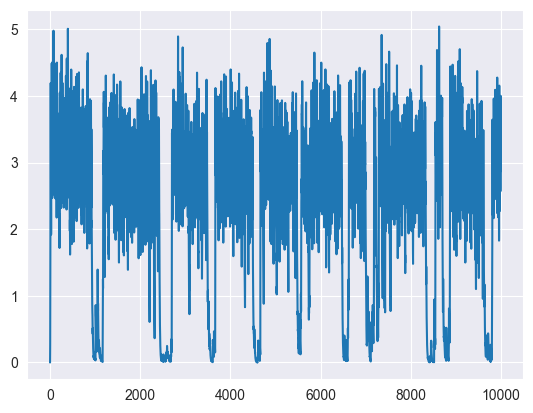

In [19]:
plt.plot(ratesG[0])

In [135]:
ratesG.shape

(3, 5000)

In [44]:
len(np.arange(0,3,0.5))

6

In [43]:
len(s_curve)

10

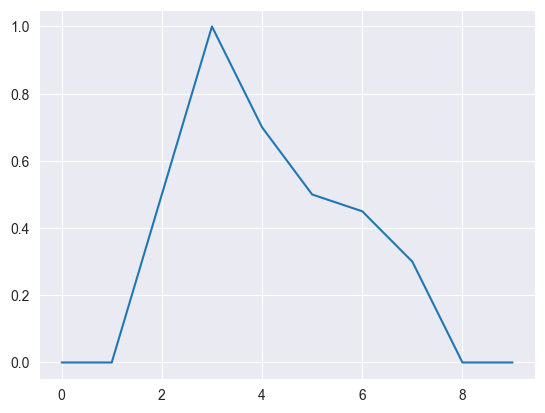

In [42]:
# model serotonin as a slow rising effect and exponential decay

# coordinates
s_curve = [0,0,0.5,1,0.7,0.5, 0.45, 0.3, 0, 0]
plt.plot(s_curve)
#plt.xticks(ticks=np.arange(0,7), labels=np.arange(0,3,0.5))

In [70]:
# interpolate 

start_time = 0  # Start time in seconds
end_time = 3  # End time in seconds
step_size = 0.0002  # Step size in seconds

time = np.arange(start_time, end_time, step_size)
trajectory = np.array([0, 1, 0.7, 0.5, 0.45, 0.3, 0])

# Interpolate the trajectory values at the specified time points
interpolated_trajectory = np.interp(time, np.linspace(start_time, end_time, len(trajectory)), trajectory)

print(interpolated_trajectory)

[0.      0.0004  0.0008  ... 0.00036 0.00024 0.00012]


In [83]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [82]:
range(int((2+1)*1000/0.2))

range(0, 15000)

In [76]:
3000/0.2

15000.0

<AxesSubplot:>

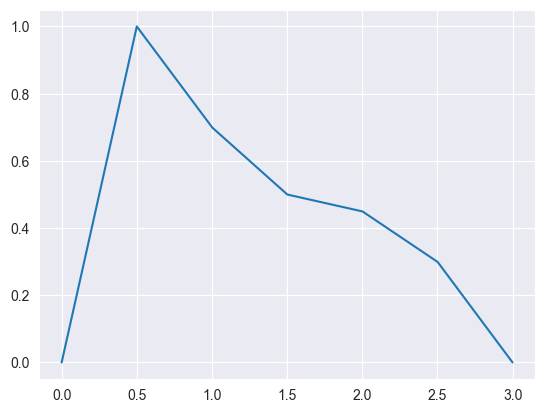

In [71]:
sns.lineplot(x=time, y=interpolated_trajectory)

(0.0, 10.0)

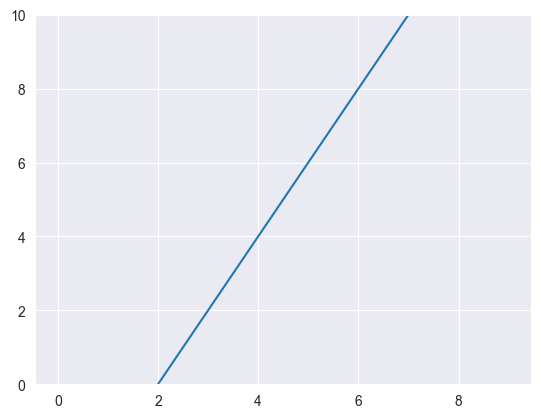

In [113]:
x_vals = np.arange(0, 10)
yE = [1 * x for x in x_vals] 
yI = [4 * x for x in x_vals] 
y_null = [0 for x in x_vals]

#plt.plot(yI)
plt.plot(yE)
#plt.plot(y_null)

plt.ylim(0, 10)

In [115]:
pip install sympy


     ---------------------------------------- 5.7/5.7 MB 2.7 MB/s eta 0:00:00
     -------------------------------------- 536.2/536.2 kB 3.7 MB/s eta 0:00:00


In [119]:
from sympy import symbols, Eq, solve

def calculate_coefficients(x, y, x_inter1, x_inter2):
    # Define variables
    a1, a2, c1, c2 = symbols('a1 a2 c1 c2')

    # Define equations
    equations = [
        Eq(y, x * a1 + c1),
        Eq(y, x * a2 + c2),
        Eq(0, x_inter1 * a1 + c1),
        Eq(0, x_inter2 * a2 + c2)
    ]

    # Solve the equations
    solution = solve(equations, (a1, a2, c1, c2))

    # Extract the solutions
    a1_value = solution[a1]
    a2_value = solution[a2]
    c1_value = solution[c1]
    c2_value = solution[c2]

    return a1_value, a2_value, c1_value, c2_value

gE 6.66666666666667
gI 16.0000000000000


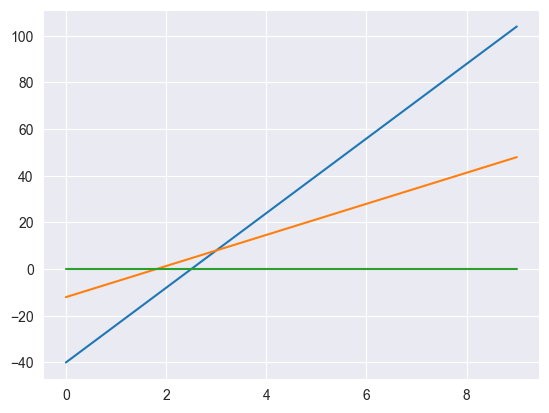

In [126]:
a1_value, a2_value, c1_value, c2_value = calculate_coefficients(3, 8, 1.8, 2.5)

x_vals = np.arange(0, 10)
yE = [a1_value * x + c1_value for x in x_vals] 
yI = [a2_value * x + c2_value for x in x_vals] 
y_null = [0 for x in x_vals]
print('gE', a1_value)
print('gI', a2_value)

plt.plot(yI)
plt.plot(yE)
plt.plot(y_null)

#plt.ylim(-5, 10)
plt.show()

In [5]:
# compute the paramters of serotonin stimulation for different G and S values
G_params = [3,4]
S_params = [40] #np.arange(0,240,40)
session_params = pd.DataFrame()
brunel_X_df = pd.DataFrame()
extra = "RateAdj1_sessions"
filename_out = ''
sessions = np.arange(0,10,1)
all_analyses = pd.DataFrame()

for G in G_params:
    for S in S_params:           
        for session in sessions:
            print(f"Run: S={S}, G={G}, session={session}")
            # load the file name
            session_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
            file_dir = os.path.join(output_dir, session_name)
            file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_{session}'
            table = compute_state_analysis(file_dir, file_name)
            # compute mean E and I firing rates
            firing_rates = load_firing_rates(file_dir, file_name)
            meanI = np.mean(firing_rates[1], axis=0)
            meanE = np.mean(firing_rates[0], axis=0)
            table['meanE'] = meanE
            table['meanI'] = meanI
            all_analyses = pd.concat((all_analyses, table))
            #brunel_X_df = pd.concat((brunel_X_df, compute_brunel_x(file_dir, file_name)))
            #session_params = pd.concat((session_params, compute_stimulation_paraxmeter(file_dir, file_name, session=session)))

#brunel_X_df.to_csv(f'brunelX_all_sessions_{extra}{filename_out}.csv', index=False) 
#session_params.to_csv(f'serotonin_stimulation_analysis_all_sessions_{extra}{filename_out}.csv', index=False)

Run: S=40, G=3, session=0
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=1
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=2
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=3
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=4
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=5
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=6
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=7
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=8
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=9
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=4, session=0
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=4, session=1
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=4, session=2
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=4, session=3
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=4, session=4
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=4, session=5
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=4, session=6
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=4, session=7
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=4, session=8
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=4, session=9
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:

G_params = [0, 1, 2]
S = 40
beta = 6
thetaE = -1
extra = ''
all_sessions = np.arange(0,10,1)
serotonin_analysis = pd.DataFrame()

serotonin_analysis = pd.read_csv(f'serotonin_analysis_all_regions_{S}_{G_params}{extra}.csv')

In [9]:
# trajectory of all regions
window_duration = 4500
pre_stim = 1000
regions = np.unique(serotonin_analysis['region_name'])

# take the mean for the combined regions 
state_transitions = serotonin_analysis.groupby(['region_name', 'S', 'session', 'G', 'time'], as_index=False).mean()

# compute bins
# for this find how many sessions there are in this set and how long one session is 
bin_size = 200
nr_sessions = len(np.unique(state_transitions['session']))
max_time = len(np.unique(state_transitions['time']))
nr_bins = max_time/bin_size
bins = np.linspace(-pre_stim, max_time-pre_stim, int(nr_bins), endpoint=False)

# compute the time points of the bins
digitized = np.digitize(np.unique(state_transitions['time']), bins, right=True)
state_transitions['bin'] = np.tile(digitized, nr_sessions*len(regions)*len([S])*len(G_params))

colors, dpi = figure_style()

data_grouped_bins = state_transitions.groupby(['region_name', 'session', 'bin', 'window', 'G'], as_index=False).mean()
data_grouped_bins['time'] = data_grouped_bins['time']/1000

# add info about DRN connectivity
drn_connect = pd.read_csv(os.path.join(model_dir, 'drn_connectivity_cre-True_hemi-3_grouping-median_thresh-0.005.csv'))
drn_connect = np.array(drn_connect)
drn_sorted = np.argsort(drn_connect.flatten())
atlas_sorted = regions[drn_sorted]

NameError: name 'model_dir' is not defined